This notebooks shows how to use `SpiderPolCal` to calibrate full Stokes spider scan observations of a polarized source, and how to derive the Mueller matrix from them.

In this case we observed 3C286 with the C-band receiver on the GBT.

In [1]:
# Set up notebook.
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Import modules.
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import least_squares

from astropy.io import fits
from astropy import units as u
from astroplan import Observer
from astropy.time import Time
from astropy.coordinates import SkyCoord

from spiderpolcal import datacal, spectral_axis, config, matrices, io

In [3]:
# Set up user variables.
path = "/home/scratch/psalas/AGBT20B_424/"
fits_file = f"{path}/AGBT20B_424_02.raw.vegas/AGBT20B_424_02.raw.vegas.B.fits"
nchan = 32768
ch_i = int(nchan*0.1)
ch_f = int(nchan*0.9)
outputdir = "/home/sandboxes/psalas/SpiderPolCal/outputs/"
outputfn = f"{outputdir}/mm_AGBT20B_424_02_4.7GHz.fits"

In [4]:
# Load the data.
hdu = fits.open(fits_file)
table = hdu[1].data

In [5]:
# Set up a telescope and source.
# We will use this later to get the parallactic angle.
gbt = Observer.at_site("GBT")
source_name = np.unique(table["OBJECT"])[0]
source = SkyCoord.from_name(source_name)
# Also save the time of the first row.
date_obs = table["DATE-OBS"][0]

In [6]:
%%time

# Select calibration scans.
cal_scans = np.unique(table[table["CAL"]=="T"]["SCAN"])
print("Scans with the noise diode ON:")
print(cal_scans)

# Data containers.
freq = u.Quantity(np.empty((len(cal_scans), nchan)), unit="Hz")
cal_data = np.empty(len(cal_scans), dtype=object)
c2K_xx = np.empty((len(cal_scans), nchan), dtype=float)
c2K_yy = np.empty((len(cal_scans), nchan), dtype=float)
tht_of = np.empty((len(cal_scans)), dtype=float)
tht_sl = np.empty((len(cal_scans)), dtype=float)
tht_ob = np.empty((len(cal_scans), nchan), dtype=float)

# Loop over scans finding the calibration parameters;
# c2K, and phase slope and offset.
for i,scan in enumerate(cal_scans):
    
    # Select the data for one calibration scan.
    scan_table = table[table["SCAN"]==scan]
    
    # Build a frequency axis.
    # It might be overkill to have a separate axis per scan,
    # as the Doppler tracking is turned off (or it should be!).
    freq[i] = spectral_axis.compute_spectral_axis(scan_table, apply_doppler=True).mean(axis=0)
    
    # Get calibration parameters.
    # Use the calibration temperature from the YY noise diode.
    # This is wrong, but this is what Paul did initially, and we want to cross check.
    cal_data[i] = datacal.DataCal(freq[i], scan_table, tcal_xx=71.400826, tcal_yy=71.400826) #58.215244)
    cal_data[i].calibrate()
    
    c2K_xx[i] = np.nanmean(cal_data[i].c2K_xx, axis=0)
    c2K_yy[i] = np.nanmean(cal_data[i].c2K_yy, axis=0)
    
    tht_of[i] = np.nanmean(cal_data[i].theta_off, axis=0)
    tht_sl[i] = np.nanmean(cal_data[i].theta_slp, axis=0)
    tht_ob[i] = np.nanmean(cal_data[i].theta_obs, axis=0)
    
mean_freq = freq[0,ch_i:ch_f].mean()

Scans with the noise diode ON:
[  6   8   9  11  12  14  15  17  18  20  21  23  24  26  27  29  30  32
  33  35  36  38  39  41  42  44  45  47  48  50  51  53  54  56  57  59
  60  62  63  65  66  68  69  71  72  74  75  77  78  80  81  83  84  86
  87  89  90  92  93  95  96  98  99 101 102 104 105 107 108 110 111 113
 114 116 117 119 120 122 123 125 126 128 129 131 132 134 135 137 138 140
 141 143 144 146 147 149]
CPU times: user 4.74 s, sys: 261 ms, total: 5 s
Wall time: 5.01 s


In [7]:
# Average the conversion factors.
# This is not really used in the end, as using the time
# resolved values works better.
c2K_xx_ = datacal.C2K(c2K_xx, chi=ch_i, chf=ch_f)
c2K_xx_.filter_outliers()
c2K_xx_.average()

c2K_yy_ = datacal.C2K(c2K_yy, chi=ch_i, chf=ch_f)
c2K_yy_.filter_outliers()
c2K_yy_.average()

Text(0, 0.5, 'Counts-to-Kelvin (K/counts)')

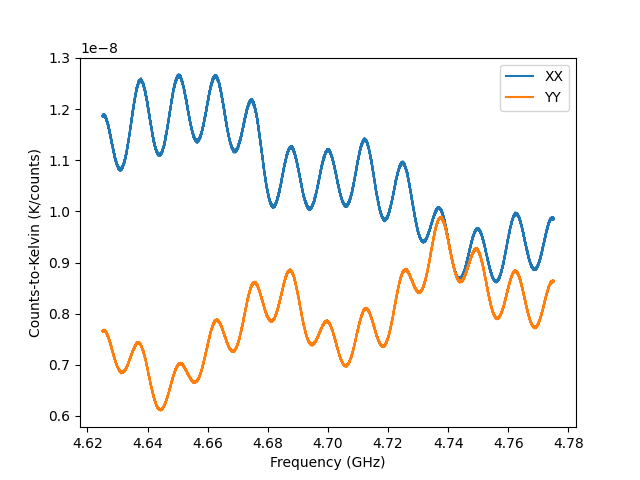

In [8]:
# Show the time averaged conversion factors.

plt.figure()
plt.plot(freq[0,ch_i:ch_f]*1e-9, c2K_xx_.c2K_avg[ch_i:ch_f], label="XX")
plt.plot(freq[0,ch_i:ch_f]*1e-9, c2K_yy_.c2K_avg[ch_i:ch_f], label="YY")
plt.legend()
plt.xlabel("Frequency (GHz)")
plt.ylabel("Counts-to-Kelvin (K/counts)")

In [9]:
%%time
# Loop over all scans, finding the ones with no noise diode fired, the Spider legs.
# This is the data we want to calibrate and ultimately use to derive the Stokes parameters.
scans = np.unique(table["SCAN"])
spider_scans = [s for s in scans if s not in cal_scans]

# Save the observed Stokes parameters, and parallactic angles into these containers.
stokes = np.empty((len(spider_scans)), dtype=object)
stokes_obs = np.empty((len(spider_scans), 4, nchan), dtype=float)
parang = np.empty((len(spider_scans)), dtype=float)

for i,scan in enumerate(spider_scans[0:]):

    scan_table = table[table["SCAN"] == scan]
    
    # Compute the parallactic angle given the source, time and telescope.
    parang[i] = gbt.parallactic_angle(Time(scan_table["DATE-OBS"][0]), source).to("deg").value
    
    # Find the closest calibration scan.
    idx = np.argmin(abs(cal_scans - scan))
    # Take the raw data and turn it into observed Stokes parameters.
    stokes[i] = datacal.Raw2Stokes(freq[idx], scan_table, 
                                   np.nanmean(c2K_xx[idx][ch_i:ch_f]), # Use a single value as a function of frequency.
                                   np.nanmean(c2K_yy[idx][ch_i:ch_f]),
                                   tht_of[idx], tht_sl[idx], tht_ob[idx],
                                   do_amp_cal=True)
    
    stokes_obs[i,0,:] = stokes[i].i_obs
    stokes_obs[i,1,:] = stokes[i].q_obs
    stokes_obs[i,2,:] = stokes[i].u_obs
    stokes_obs[i,3,:] = stokes[i].v_obs

CPU times: user 23.6 s, sys: 2.72 s, total: 26.3 s
Wall time: 27.4 s


In [10]:
# Average in frequency.
si = stokes_obs[:,0,ch_i:ch_f].mean(axis=1)
sq = stokes_obs[:,1,ch_i:ch_f].mean(axis=1)
su = stokes_obs[:,2,ch_i:ch_f].mean(axis=1)
sv = stokes_obs[:,3,ch_i:ch_f].mean(axis=1)

Text(0, 0.5, 'Fractional Stokes parameter')

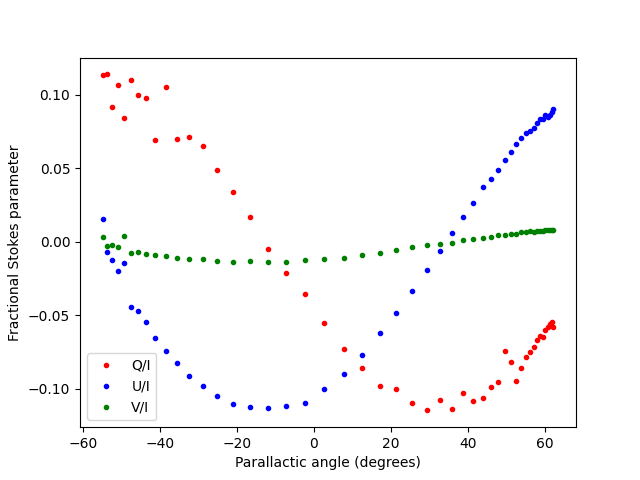

In [11]:
# Plot the fractional Stokes parameters as a function of parallactic angle.
# This should look like Paul's result.
plt.figure()
plt.plot(parang, sq/si, 'r.', label="Q/I")
plt.plot(parang, su/si, 'b.', label="U/I")
plt.plot(parang, sv/si, 'g.', label="V/I")
plt.legend()
plt.xlabel("Parallactic angle (degrees)")
plt.ylabel("Fractional Stokes parameter")

In [12]:
# Use the source properties to set the starting values.
# This is not required, but is also useful to have for cross-checking.
chi = np.deg2rad(33)
plin = 11.5/100. # %
q_teo = plin/np.sqrt(1 + np.tan(2*chi)**2.)
u_teo = q_teo*np.tan(2*chi)
print(np.sqrt(q_teo**2+u_teo**2.)*100., np.rad2deg(0.5*np.arctan2(u_teo, q_teo)))
print(q_teo, u_teo)

11.5 33.0
0.04677471395371702 0.1050577276288991


In [13]:
# Set up problem to be fit.
# This part tells what parameters should be fit, 
# and for those not fit, what their values should be.
params = {"dG":{"fit":True, "value":9e-4},
          "psi":{"fit":True, "value": np.pi},
          "alpha":{"fit":True, "value":0.0},
          "epsilon":{"fit":True},
          "phi":{"fit":True, "value": np.pi},
          "q_src":{"fit":True, "value": q_teo},
          "u_src":{"fit":True, "value": u_teo},
          "v_src":{"fit":False, "value":0},
         }
# This part sets the starting guess for the parameters to be fit.
coefs = [50e-3, -np.pi*0.9, np.pi/4., 0.2, 0., q_teo*5, u_teo*5]

In [14]:
s_obs = np.hstack((si/si, -sq/si, -su/si, sv/si))

In [15]:
r = least_squares(matrices.cost_mueller, 
                  coefs,
                  args=(np.deg2rad(parang), s_obs, params),
                  # kwargs=kwargs,
                  max_nfev=10000,
                  loss="soft_l1",
                  f_scale=0.01,
                  ftol=1e-12,
                  xtol=1e-12,
                  gtol=1e-12,
                 )

In [16]:
# Check that this finished without problems.
r

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-2.546e-05 -4.455e-05 ... -2.463e-04 -4.074e-04]
           x: [ 2.168e-04 -1.079e-01  3.599e-04  2.177e-03 -2.342e-01
                4.537e-02  1.003e-01]
        cost: 0.0014527346347732104
         jac: [[ 5.487e-02 -0.000e+00 ... -3.950e-03  1.532e-03]
               [ 5.464e-02 -0.000e+00 ... -4.009e-03  1.369e-03]
               ...
               [ 0.000e+00  8.845e-02 ... -9.021e-02 -5.869e-02]
               [ 0.000e+00  8.927e-02 ... -8.922e-02 -6.003e-02]]
        grad: [ 6.925e-12  3.598e-10 -3.665e-10  5.380e-12 -3.041e-11
               -1.229e-11  2.115e-12]
  optimality: 3.6654079120859717e-10
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00  0.000e+00]
        nfev: 26
        njev: 21

In [17]:
mm_pars = matrices.parse_fit(params, r.x)
mm_pars

{'dG': 0.0002168485416027043,
 'psi': -0.10787330305883028,
 'alpha': 0.00035988216065520865,
 'epsilon': 0.0021769658858904668,
 'phi': -0.2342134412615615,
 'q_src': 0.045366530158400496,
 'u_src': 0.10031820901897127,
 'v_src': 0}

In [18]:
# Extract the source Stokes parameters from the Mueller matrix fit.
q_src = mm_pars["q_src"]
u_src = mm_pars["u_src"]
v_src = mm_pars["v_src"]
pa = np.deg2rad(parang)

In [19]:
# Print the source linear polarization fraction and polarization angle.
p_lin_obs = np.sqrt(q_src**2 + u_src**2)*100.
chi_obs = np.rad2deg(0.5*np.arctan2(u_src, q_src))
print(f"{source_name} fractional linear polarization {p_lin_obs:.2f}% at polarization angle: {chi_obs:.2f} deg")

3C286 fractional linear polarization 11.01% at polarization angle: 32.83 deg


Text(0, 0.5, 'Fractional Stokes parameter')

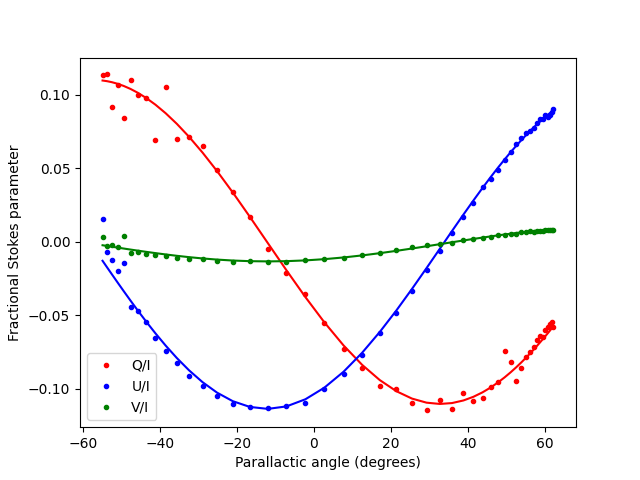

In [20]:
# Compare the fit to observations.
q_src_rot = q_src * np.cos(2.*pa) + u_src * np.sin(2.*pa)
u_src_rot = -q_src * np.sin(2.*pa) + u_src * np.cos(2.*pa)

q_mod = matrices.q_mod(pa, *list(mm_pars.values())[:-3], q_src_rot, u_src_rot, v_src)
u_mod = matrices.u_mod(pa, *list(mm_pars.values())[:-3], q_src_rot, u_src_rot, v_src)
v_mod = matrices.v_mod(pa, *list(mm_pars.values())[:-3], q_src_rot, u_src_rot, v_src)

plt.figure()
plt.plot(parang, sq/si, 'r.', label="Q/I")
plt.plot(parang, -q_mod, c='r')
plt.plot(parang, su/si, 'b.', label="U/I")
plt.plot(parang, -u_mod, c='b')
plt.plot(parang, sv/si, 'g.', label="V/I")
plt.plot(parang, v_mod, c='g')

plt.legend()
plt.xlabel("Parallactic angle (degrees)")
plt.ylabel("Fractional Stokes parameter")

In [21]:
# Finally, the Mueller matrix!
mueller_matrix = matrices.mueller(*list(mm_pars.values())[:-3])
print(mueller_matrix)

[[ 1.00000000e+00  1.09151530e-04  4.23505718e-03 -1.01037336e-03]
 [ 1.08424271e-04  9.99999741e-01  0.00000000e+00  7.19764259e-04]
 [ 4.10165065e-03 -7.74928509e-05  9.94187315e-01  1.07664183e-01]
 [-1.46054232e-03 -7.15580496e-04 -1.07664211e-01 -9.94187058e-01]]


In [22]:
io.mm_fit_to_fits(outputfn, mueller_matrix, mm_pars, params, 
                  mean_freq, date_obs, overwrite=True)

Text(0, 0.5, 'Fractional Stokes parameter')

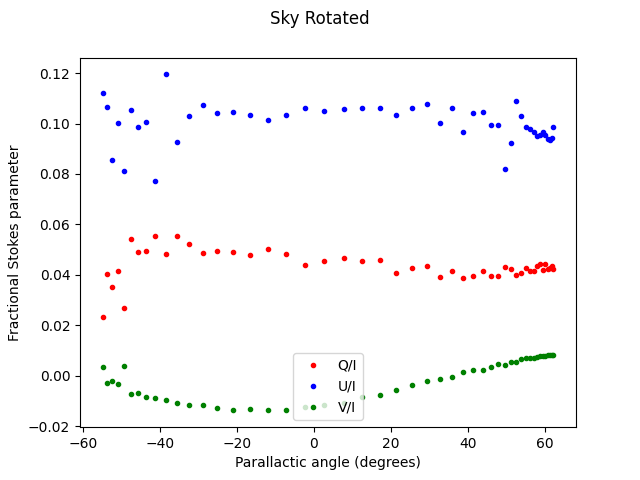

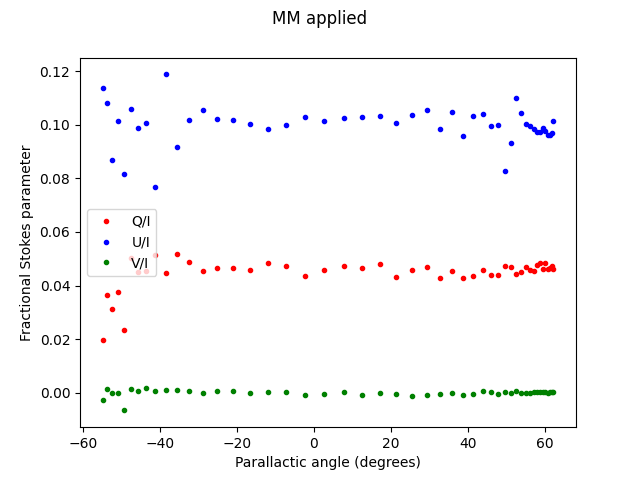

In [23]:
# More sanity checks.
# Rotating the fractional Stokes parameters should flatten the parallactic angle dependance.
# Applying the Mueller matrix should flatten Stokes V.

s_cor = np.empty((len(pa),4,1), dtype=float)
s_rot = np.empty((len(pa),4,1), dtype=float)

for i,p in enumerate(pa):
    msky = matrices.sky_rot(p)
    mm = matrices.mueller(*list(mm_pars.values())[:-3])
    msky_inv = np.linalg.inv(msky)
    mm_inv = np.linalg.inv(mm)
    s_rot[i] = np.dot(msky_inv, np.matrix([[1., -(sq/si)[i], -(su/si)[i], (sv/si)[i]]]).T)
    s_cor[i] = np.dot(msky_inv, np.dot(mm_inv, np.matrix([[1., -(sq/si)[i], -(su/si)[i], (sv/si)[i]]]).T))
    

# Sky rotated.
plt.figure()
plt.suptitle("Sky Rotated")
plt.plot(parang, s_rot[:,1,0], 'r.', label="Q/I")
plt.plot(parang, s_rot[:,2,0], 'b.', label="U/I")
plt.plot(parang, s_rot[:,3,0], 'g.', label="V/I")
plt.legend()
plt.xlabel("Parallactic angle (degrees)")
plt.ylabel("Fractional Stokes parameter")


# Matrix correceted.
plt.figure()
plt.suptitle("MM applied")
plt.plot(parang, s_cor[:,1,0], 'r.', label="Q/I")
plt.plot(parang, s_cor[:,2,0], 'b.', label="U/I")
plt.plot(parang, s_cor[:,3,0], 'g.', label="V/I")
plt.legend()
plt.xlabel("Parallactic angle (degrees)")
plt.ylabel("Fractional Stokes parameter")